In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.integrate import solve_ivp
from scipy.sparse import lil_matrix
from qutip import Qobj, sesolve
import qutip as qt
from functools import partial

In [2]:
#####################
# Define Variables and Relevant Functions
#####################

J = 1 # satisfies initial condition h(0)/J = 1
# T_vals = np.linspace(0.05, 100, 300)
T_vals = [1, 10]
N_t = 20 # Number of time steps within T
I_star_final, I_star_final_driven = np.zeros(len(T_vals)), np.zeros(len(T_vals))

def control(t, T):
    """Transverse field h(t) = cos^2(pi * t/(2 * T))"""
    return np.cos((np.pi * t) / (2 * T))**2

def control_deriv(t, T):
    """h_dot (t) = -pi/(2T) * sin(pi * t/T)
        This is used to build the counterdiabatically driven Hamiltonian H_{CD}"""
    return (-np.pi / (2 * T)) * np.sin((np.pi * t) / T)

def hamiltonian(t, T, J):
    """4x4 Hamiltonian matrix in the basis [uu, dd, ud, du]
        We are taking hbar = 1 for simplicity"""
    h = control(t, T)
    a, b, c = J/4, -J/4, h/2
    return np.array([
        [a, 0, c, c],
        [0, a, c, c],
        [c, c, b, 0],
        [c, c, 0, b]
    ], dtype=complex)

def K_matrix():
    """4x4 matrix corresponding to just the (S^x_1 + S^x_2) piece of the original Hamiltonian H(t),
        i.e. without the h(t) factor in, in the {uu, dd, ud, du} basis.
        This is used to build the counterdiabatically driven Hamiltonian H_{CD}.
        Remember we are taking hbar=1"""
    a = 1/2
    return np.array([
        [0, 0, a, a],
        [0, 0, a, a],
        [a, a, 0, 0],
        [a, a, 0, 0]
    ], dtype=complex)

K = K_matrix()

def gauge_potential(t, T, J):
    """Build the gauge potential term in the counterdiabatically driven Hamiltonian H_cd from the original undriven Hamiltonian,
            in the fixed [uu, dd, ud, du] basis.
        The Berry formula for the gauge potential piece is defined in terms of the instantaneous eigenbasis,
            so we need to transform between this and the [uu, dd, ud, du] basis."""
    
    # Diagonalise original Hamiltonian
    H_t = hamiltonian(t, T, J)
    values, vectors = np.linalg.eigh(H_t)   # values sorted ascending

    # Now build the new gauge potential piece
    U_dag = vectors.conj().T
    transformed_K = U_dag @ K @ vectors

    denom = values[None, :] - values[:, None]   # Matrix of energy differences: (m,n) -> E_n - E_m, shape (4, 4)
    nondegen_mask = np.abs(denom) > 1e-12
    offdiag_mask = (~np.eye(len(values), dtype=bool)) & nondegen_mask # mask out diagonal to avoid dividing by 0
    A_h = np.zeros_like(transformed_K, dtype=complex)
    A_h[offdiag_mask] = 1j * transformed_K[offdiag_mask] / denom[offdiag_mask] # Fill in off-diagonal entries only, leave diagonal zero (gauge choice)

    A_h_comp_basis = vectors @ A_h @ U_dag

    return A_h_comp_basis

def hamiltonian_cd(t, T, J):
    """Compose the full counterdiabatically driven Hamiltonian H_cd in the [uu, dd, ud, du] basis."""
    
    A_h = gauge_potential(t, T, J)
    H_t = hamiltonian(t, T, J)
    H_cd = H_t + control_deriv(t, T) * A_h

    return H_cd

def qt_hamiltonian(t, args):
    """Define the Hamiltonian using the qutip library.
        This will be useful to solve the Schroedinger equation later (using QuTip instead of solve_ivp)"""
    J = args['J']
    T = args['T']
    H_np = hamiltonian(t, T, J)
    return Qobj(H_np)

def qt_hamiltonian_cd(t, args):
    """Define the driven Hamiltonian using the qutip library.
        This will be useful to solve the Schroedinger equation later (using QuTip instead of solve_ivp)"""
    J = args['J']
    T = args['T']
    H_np = hamiltonian_cd(t, T, J)
    return Qobj(H_np)

# ---- Redefine functions using permuted basis to match QuTip ----
def hamiltonian_permuted(t, T, J):
    """4x4 Hamiltonian matrix in the basis {uu, ud, du, dd}, so essentially a permutation
        of the above hamiltonian() function.
        Take hbar = 1 for simplicity again."""
    h = control(t, T)
    a, b, c = J/4, -J/4, h/2
    return np.array([
        [a, c, c, 0],
        [c, b, 0, c],
        [c, 0, b, c],
        [0, c, c, a]
    ], dtype=complex)

def K_matrix_permuted():
    """4x4 matrix corresponding to just the (S^x_1 + S^x_2) piece of the original Hamiltonian H(t),
        i.e. without the h(t) factor in, in the permuted {uu, ud, du, dd} basis.
        This is used to build the counterdiabatically driven Hamiltonian H_{CD}.
        Remember we are taking hbar=1"""
    a = 1/2
    return np.array([
        [0, a, a, 0],
        [a, 0, 0, a],
        [a, 0, 0, a],
        [0, a, a, 0]
    ], dtype=complex)

K_permuted = K_matrix_permuted()

def gauge_potential_permuted(t, T, J):
    """Build the gauge potential term in the counterdiabatically driven Hamiltonian H_cd from the original undriven Hamiltonian,
            in the permuted [uu, ud, du, dd] basis.
        The Berry formula for the gauge potential piece is defined in terms of the instantaneous eigenbasis,
            so we need to transform between this and the [uu, dd, ud, du] basis."""
    
    # Diagonalise original Hamiltonian
    H_t = hamiltonian_permuted(t, T, J)
    values, vectors = np.linalg.eigh(H_t)   # values sorted ascending

    # Now build the new gauge potential piece
    U_dag = vectors.conj().T
    transformed_K = U_dag @ K_permuted @ vectors

    denom = values[None, :] - values[:, None]   # Matrix of energy differences: (m,n) -> E_n - E_m, shape (4, 4)
    nondegen_mask = np.abs(denom) > 1e-12
    offdiag_mask = (~np.eye(len(values), dtype=bool)) & nondegen_mask # mask out diagonal to avoid dividing by 0
    A_h = np.zeros_like(transformed_K, dtype=complex)
    A_h[offdiag_mask] = 1j * transformed_K[offdiag_mask] / denom[offdiag_mask] # Fill in off-diagonal entries only, leave diagonal zero (gauge choice)

    A_h_comp_basis = vectors @ A_h @ U_dag

    return A_h_comp_basis



In [9]:
#####################
# Pipeline to Find Infidelities
#####################

for k, T in enumerate(T_vals):
    t_vals = np.linspace(0, T, N_t)

    # region
    #####################
    # Diagonalise Original Hamiltonian
    #####################

    # storage: eigenvalues [N_t, 4], eigenvectors [N_t, 4, 4]
    e_vals = np.zeros((N_t, 4), dtype=float)
    e_vecs = np.zeros((N_t, 4, 4), dtype=complex)

    for i, t in enumerate(t_vals):
        H_t = hamiltonian(t, T, J)
        values, vectors = np.linalg.eigh(H_t)   # values sorted ascending
        e_vals[i, :] = values
        e_vecs[i, :, :] = vectors             # columns are eigenvectors

    # Store the instantaneous ground states of the original Hamiltonian
    ground_energies = e_vals[:, 0]        # shape (N_t,)
    ground_states  = e_vecs[:, :, 0]      # shape (N_t, 4)

    psi_init = ground_states[0]
    # psi_star = ground_states[-1]   # |psi*>
    psi_star = np.array([0, 0, 1/np.sqrt(2), 1/np.sqrt(2)], dtype=complex)
    # endregion

    #region
    #####################
    # Solve Time-Dependent Schroedinger Eqn (for both hamiltonians)
    #####################

    # # ---- Using scipy solve_ivp ----
    # y0 = psi_init # Initial condition is psi_init as we start in the ground state

    # time_evolved_psi_original = scipy.integrate.solve_ivp(
    #     schrodinger_rhs,
    #     (0, T),
    #     y0,
    #     t_eval=t_vals,
    #     args=(J, T),
    #     rtol=1e-9,
    #     atol=1e-9)
    # psi_t_original = time_evolved_psi_original.y.T   # shape (N_t, 4) 

    # time_evolved_psi_driven = scipy.integrate.solve_ivp(
    #     schrodinger_rhs_cd,
    #     (0, T),
    #     y0,
    #     t_eval=t_vals,
    #     args=(J, T),
    #     rtol=1e-9,
    #     atol=1e-9)
    # psi_t_driven = time_evolved_psi_driven.y.T   # shape (N_t, 4)

    # ---- Now using QuTip instead ----
    psi0 = Qobj(psi_init)  # initial condition as Qobj ket
    args = {'J': J, 'T': T}

    sol = sesolve(qt_hamiltonian, psi0, t_vals, e_ops=[], args=args)
    psi_t_original_list = sol.states                     # list of length N_t
    psi_t_original = np.vstack([psi.full().ravel() for psi in psi_t_original_list])  # (N_t, 4)

    sol_cd = sesolve(qt_hamiltonian_cd, psi0, t_vals, e_ops=[], args=args)
    psi_t_driven_list = sol_cd.states
    psi_t_driven = np.vstack([psi.full().ravel() for psi in psi_t_driven_list])
    # endregion

    #region
    #####################
    # Calculate Infidelities, Plot
    #####################

    # ---- original infidelities ----
    I  = np.zeros(N_t)
    I_star = np.zeros(N_t)

    for i in range(N_t):
        I[i]      = 1 - np.abs(np.vdot(ground_states[i], psi_t_original[i]))**2
        I_star[i] = 1 - np.abs(np.vdot(psi_star, psi_t_original[i]))**2
    I[-1] = 1 - np.abs(np.vdot(psi_star, psi_t_original[i]))**2
    # store final target infidelity for this T
    I_star_final[k] = I_star[-1]


    # ---- driven infidelities ----
    I_driven  = np.zeros(N_t)
    I_star_driven = np.zeros(N_t)

    for i in range(N_t):
        I_driven[i]      = 1 - np.abs(np.vdot(ground_states[i], psi_t_driven[i]))**2
        I_star_driven[i] = 1 - np.abs(np.vdot(psi_star, psi_t_driven[i]))**2
    I_driven[-1] = 1 - np.abs(np.vdot(psi_star, psi_t_driven[i]))**2
    I_star_final_driven[k] = I_star_driven[-1]

    # plt.figure(figsize=(5, 3))
    # plt.plot(t_vals, I, color='orange', marker='x', markersize=3, linestyle='-', label='$I(t)$')
    # plt.plot(t_vals, I_star, color='blue', marker='o', markersize=3, linestyle='--', label='$I^*(t)$')
    # plt.plot(t_vals, I_driven, color='green', marker='+', markersize=3, linestyle='-', label='$I_{CD}(t)$')
    # plt.plot(t_vals, I_star_driven, color='purple', marker='v', markersize=3, linestyle='--', label='$I^*_{CD}(t)$')
    # # plt.title(fr'$I(t)$, $I^*(t)$, $I_{{CD}}(t)$ and $I^*_{{CD}}(t)$ for $T={T}$')
    # plt.title(fr'Infidelities for $T={T}$')
    # plt.xlabel("Time $t$")
    # plt.ylim(0,1)
    # plt.legend()
    # plt.tight_layout()
    # plt.show()    
    # endregion

#region
#####################
# Identifying Adiabatic Regime
#####################

# Define adiabatic regime
threshold = 0.05

mask_original = I_star_final < threshold
mask_driven = I_star_final_driven < threshold

if np.any(mask_original):
    first_idx = np.where(mask_original)[0][0]
    T_adiabatic = T_vals[first_idx]
    print("First T with I*(T) <", threshold, "is:", T_adiabatic)

if np.any(mask_driven):
    first_idx = np.where(mask_driven)[0][0]
    T_adiabatic = T_vals[first_idx]
    print("First T with $I*_{CD}(T)$ <", threshold, "is:", T_adiabatic)

# plt.figure()
# plt.scatter(T_vals, I_star_final, marker='x', s=10, label='$I^*(T)$ - Original')
# plt.scatter(T_vals, I_star_final_driven, marker='o', s=10, label='$I^*_{CD}(T)$ - Counterdriven')
# # plt.axhline(threshold, color='r', linestyle='--')
# plt.xlabel("T")
# # plt.ylabel(r"$I^*(T)$")
# plt.xlim(0,)
# plt.ylim(top=0.4)
# plt.legend()
# plt.tight_layout()
# plt.show()
#endregion


First T with $I*_{CD}(T)$ < 0.05 is: 1


['II', 'IX', 'IY', 'IZ', 'XI', 'XX', 'XY', 'XZ', 'YI', 'YX', 'YY', 'YZ', 'ZI', 'ZX', 'ZY', 'ZZ']
Gram matrix G:
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]
alpha = 1.9999999999999996j
beta = -1.9999999999999996j
gamma = 1.9999999999999996j


max |a3_0| = 0.023522588098043272
max |Im(a3_0)| = 0.0
mu reached: 300.0 status: 0 message: The solver successfully reached the end of the integration interval.
mu reached: 300.0 event hit: False
final off-subspace max: 0.18678534805225028


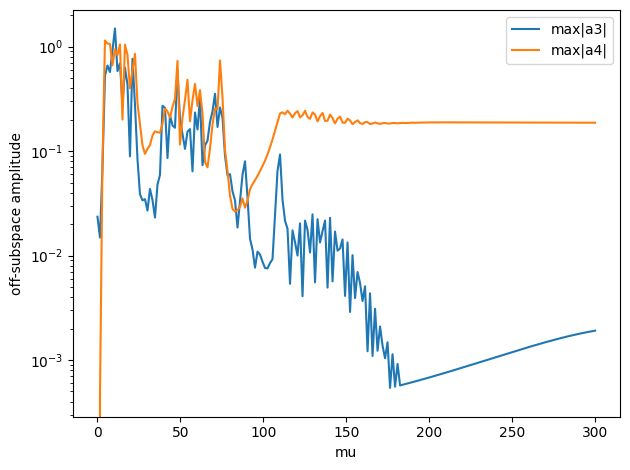

initial off-sub max: 0.023522588098043272
final off-sub max: 0.18678534805225028
invariant drift max over mu: 0.010371439171843744


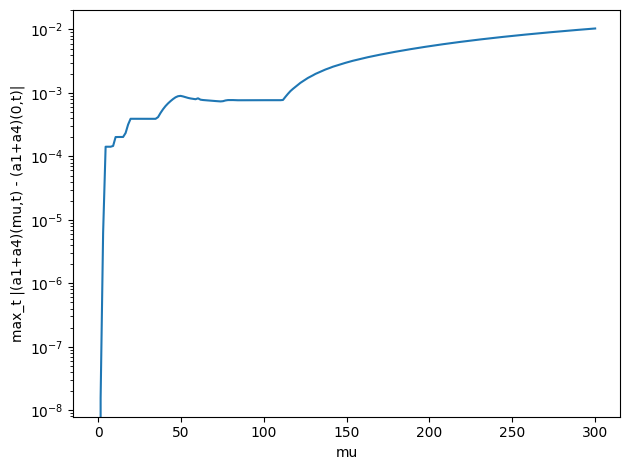

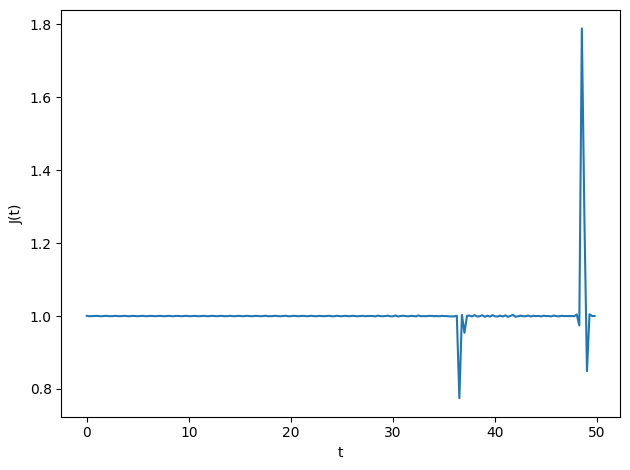

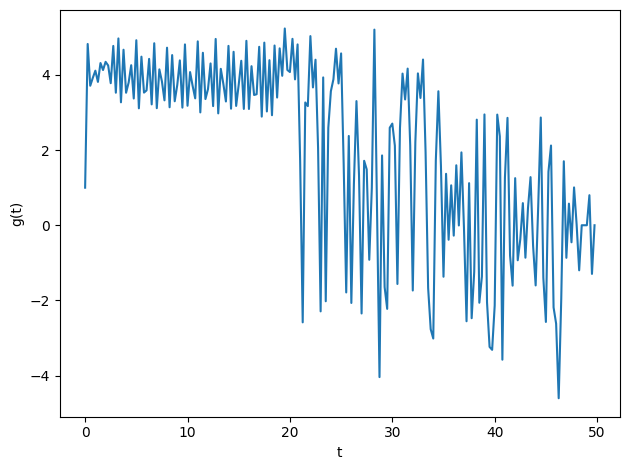

In [ ]:
d = 4  # Hilbert space dimension for 2 qubits

# region
#####################
# Define 16D Operator Basis From Pauli String
#####################

# single-qubit basis: 0 = I, 1 = X, 2 = Y, 3 = Z
one_qubit = [qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()]
labels = ['I', 'X', 'Y', 'Z']

basis_ops = []
basis_labels = []
for i, Pi in enumerate(one_qubit):
    for j, Pj in enumerate(one_qubit):
        op = qt.tensor(Pi, Pj)       # σ_i ⊗ σ_j
        basis_ops.append(op)
        basis_labels.append(labels[i] + labels[j])  # "IX", "ZX", etc.

basis_dict = dict(zip(basis_labels, basis_ops))
print(basis_labels)
# print(basis_ops)
# endregion

# region
#####################
# Define Orthonormal 4D Operator Subspace
#####################
# From A_decomp we see that qt_gauge is proportional to [O1, O2] = 2j(YZ + ZY), so it makes sense to take this as the third member of the 4D subspace
# O3_raw is exactly the same as qt_gauge, just built from Hilber-Schmidt coeffs, so avoids tiny numerical errors of order 1e-17

def hs_inner(A, B):
    return (A.dag() * B).tr() / d

def gram_matrix(basis):
    """Compute and print the Gram matrix of the 4D operator basis.
        Useful to check orthogonality/orthonormality.
        Gram matrix G_{ab} = <O_a, O_b>_HS"""

    G = np.zeros((4, 4), dtype=complex)
    for a in range(4):
        for b in range(4):
            G[a, b] = hs_inner(basis[a], basis[b])
    print("Gram matrix G:")
    print(G)

# Define unscaled basis
O1_raw = basis_dict['ZZ']
O2_raw = (basis_dict['IX'] + basis_dict['XI'])
O3_raw = basis_dict['YZ'] + basis_dict['ZY']
O4_raw = basis_dict['YY']

sub_basis = [O1_raw, O2_raw, O3_raw, O4_raw] # Orthogonal but not orthonormal basis
sub_norms = [hs_inner(op, op) for op in sub_basis]
print(sub_norms)

# Rescale to define orthonormal basis
for i in range(len(sub_basis)):
    sub_basis[i] = sub_basis[i] / np.sqrt(sub_norms[i])
O1, O2, O3, O4 = sub_basis
# print(sub_norms)
# print(sub_basis)

gram_matrix(sub_basis) # 4x4 identity matrix => orthonormal basis

def project(H):
    """Project any matrix H onto the 4D effective orthonormal operator basis we consider.
        Return the components of the 4D vector.
        Use the orthogonal projection matrix with the Hilbert-Schmidt inner product as used above."""
    components = []
    for op in sub_basis:
        c = hs_inner(op, H)
        components.append(c)

    return components

def project_2D(H):
    """Project any matrix H to the 2D subspace spanned by operator basis elements O1, O2.
            Return the actual matrix, not the component vector in operator space.
            Use the orthogonal projection matrix with the Hilbert-Schmidt inner product as used above."""
    O1_comp = hs_inner(O1, H)
    O2_comp = hs_inner(O2, H)
    
    projection = O1_comp * O1 + O2_comp * O2
    return projection

def generator(H):
    """Build the generator of the Wegner-like flow as K_mu = i[P(H), H]."""
    projection = project_2D(H)
    return 1j*qt.commutator(projection, H)

# Define parameters for values of different commutators (structure constants) which will be useful when solving the PDE for coeffs
alpha_comm = project(qt.commutator(O1, O2))
alpha = alpha_comm[2]
beta_comm = project(qt.commutator(O1, O3))
beta = beta_comm[1]
gamma_comm = project(qt.commutator(O2, O3))
gamma = gamma_comm[0]
print(f'alpha = {alpha}')
print(f'beta = {beta}')
print(f'gamma = {gamma}')
print('\n')
# endregion

#####################
# Functions To Solve PDE Flow Equations
#####################

# def build_initial_conditions(T, J, Nt):
#     """For the above orthonormal 4D subspace, build the initial
#         H_mu at mu=0 which is H_CD(t) = H(t) + hdot(t)*A_h(t)."""
    
#     tgrid = np.linspace(0, T, Nt)
#     h = np.array([control(t, T) for t in tgrid], dtype=float)
#     hdot = np.array([control_deriv(t, T) for t in tgrid], dtype=float)

#     a1_0 = (J/4) * np.ones(Nt, dtype=complex) # Compare O1 to J*S^z_1*S^z_2 with scaling
#     a2_0 = (h/np.sqrt(2)).astype(complex) # Compare O2 to h(t)*(S^x_1 + S^x_2) with scaling

#     # a3 from hdot(t)*A_h(t); with orthonormal O3, coefficient is <O3, A_h>
#     overlaps = np.zeros(Nt, dtype=complex)
#     for k, t in enumerate(tgrid):
#         gauge_piece = qt.Qobj(gauge_potential_permuted(t, T, J), dims=[[2,2],[2,2]])
#         overlaps[k] = np.real_if_close(hs_inner(O3, gauge_piece), tol=1e-12)
#     a3_0 = (hdot * overlaps).astype(complex)

#     a4_0 = np.zeros(Nt, dtype=complex) # in H_{CD} there is no YY present initially

#     y0 = np.concatenate([a1_0, a2_0, a3_0, a4_0])
#     return tgrid, y0

def build_initial_conditions(T, J, Nt):
    tgrid = np.linspace(0, T, Nt, endpoint=False)  # <- also avoid exact degeneracy at t=T
    h = np.array([control(t, T) for t in tgrid], dtype=float)
    hdot = np.array([control_deriv(t, T) for t in tgrid], dtype=float)

    a1_0 = (J/4) * np.ones(Nt, dtype=float)
    a2_0 = (h/np.sqrt(2)).astype(float)

    overlaps = np.zeros(Nt, dtype=float)
    for k, t in enumerate(tgrid):
        gauge_piece = qt.Qobj(gauge_potential_permuted(t, T, J), dims=[[2,2],[2,2]])
        overlaps[k] = float(np.real(hs_inner(O3, gauge_piece)))

    a3_0 = (hdot * overlaps).astype(float)
    a4_0 = np.zeros(Nt, dtype=float)

    y0 = np.concatenate([a1_0, a2_0, a3_0, a4_0]).astype(float)
    return tgrid, y0

def d_dt(f, tgrid):
    """2nd-order accurate finite difference via numpy.gradient
        (handles endpoints one-sided)."""
    return np.gradient(f, tgrid, edge_order=2)

def make_D4(tgrid):
    """4th-order centered derivative, 2nd-order one-sided at boundaries."""
    Nt = len(tgrid)
    h = tgrid[1] - tgrid[0]
    D = np.zeros((Nt, Nt), dtype=float)

    # 4th-order centered stencil for interior points
    for i in range(2, Nt-2):
        D[i, i-2] =  1/(12*h)
        D[i, i-1] = -8/(12*h)
        D[i, i+1] =  8/(12*h)
        D[i, i+2] = -1/(12*h)

    # 2nd-order one-sided at boundaries
    # i=0: (-3 f0 + 4 f1 - f2)/(2h)
    D[0, 0] = -3/(2*h); D[0, 1] =  4/(2*h); D[0, 2] = -1/(2*h)
    # i=1: (-3 f1 + 4 f2 - f3)/(2h)  (still one-sided but shifted)
    D[1, 1] = -3/(2*h); D[1, 2] =  4/(2*h); D[1, 3] = -1/(2*h)
    # i=Nt-2:
    D[-2, -2] =  3/(2*h); D[-2, -3] = -4/(2*h); D[-2, -4] =  1/(2*h)
    # i=Nt-1:
    D[-1, -1] =  3/(2*h); D[-1, -2] = -4/(2*h); D[-1, -3] =  1/(2*h)

    return D

def make_D2(tgrid):
    Nt = len(tgrid)
    h = tgrid[1] - tgrid[0]
    D2 = np.zeros((Nt, Nt), dtype=float)
    for i in range(1, Nt-1):
        D2[i, i-1] = 1/h**2
        D2[i, i]   = -2/h**2
        D2[i, i+1] = 1/h**2
    # simple Neumann-ish boundaries
    D2[0,0] = -2/h**2; D2[0,1] = 2/h**2
    D2[-1,-1] = -2/h**2; D2[-1,-2] = 2/h**2
    return D2

# def flow_rhs(mu, y, tgrid):
#     """Method-of-lines RHS: dy/dmu = F(y) for stacked y=[a1,a2,a3,a4] over tgrid."""
#     Nt = tgrid.size
#     a1 = y[0:Nt]
#     a2 = y[Nt:2*Nt]
#     a3 = y[2*Nt:3*Nt]
#     a4 = y[3*Nt:4*Nt]

#     # product fields that appear inside time derivative terms in PDE system
#     p23 = a2 * a3
#     p13 = a1 * a3
#     p24 = a2 * a4

#     dt_p23 = d_dt(p23, tgrid)
#     dt_p13 = d_dt(p13, tgrid)
#     dt_p24 = d_dt(p24, tgrid)

#     # PDE system
#     da1 = 4*(a1*(a3**2) + (a2**2)*a4) - 2*dt_p23
#     da2 = 4*a2*(-a1*a4 + 2*(a3**2) + (a4**2)) + 2*dt_p13
#     da3 = 4*a3*(-(a1**2) + a1*a4 - 2*(a2**2)) - 2*dt_p24
#     da4 = -4*(a1*(a3**2) + (a2**2)*a4) + 2*dt_p23

#     return np.concatenate([da1, da2, da3, da4])

# def flow_rhs_D(mu, y, tgrid, D=None, enforce_neumann=False):
#     y = np.asarray(y, dtype=float)
#     Nt = tgrid.size
#     a1 = y[0:Nt]
#     a2 = y[Nt:2*Nt]
#     a3 = y[2*Nt:3*Nt]
#     a4 = y[3*Nt:4*Nt]

#     p23 = a2 * a3
#     p13 = a1 * a3
#     p24 = a2 * a4

#     if D is None:
#         dt_p23 = np.gradient(p23, tgrid, edge_order=2)
#         dt_p13 = np.gradient(p13, tgrid, edge_order=2)
#         dt_p24 = np.gradient(p24, tgrid, edge_order=2)
#     else:
#         dt_p23 = D @ p23
#         dt_p13 = D @ p13
#         dt_p24 = D @ p24

#     # optional “sensible boundary handling”: enforce ∂t(...) = 0 at endpoints
#     # (often appropriate here because hdot(0)=hdot(T)=0 so products tend to be flat at ends)
#     if enforce_neumann:
#         for arr in (dt_p23, dt_p13, dt_p24):
#             arr[0] = 0.0
#             arr[-1] = 0.0

#     da1 = 4*(a1*(a3**2) + (a2**2)*a4) - 2*dt_p23
#     da2 = 4*a2*(-a1*a4 + 2*(a3**2) + (a4**2)) + 2*dt_p13
#     da3 = 4*a3*(-(a1**2) + a1*a4 - 2*(a2**2)) - 2*dt_p24
#     da4 = -4*(a1*(a3**2) + (a2**2)*a4) + 2*dt_p23

#     return np.concatenate([da1, da2, da3, da4]).astype(float)

def flow_rhs_D(mu, y, tgrid, D=None, D2=None, nu=0.0, enforce_neumann=False):
    y = np.asarray(y, dtype=float)
    Nt = tgrid.size
    a1 = y[0:Nt]; a2 = y[Nt:2*Nt]; a3 = y[2*Nt:3*Nt]; a4 = y[3*Nt:4*Nt]

    p23 = a2*a3; p13 = a1*a3; p24 = a2*a4
    dt_p23 = (D @ p23) if D is not None else np.gradient(p23, tgrid, edge_order=2)
    dt_p13 = (D @ p13) if D is not None else np.gradient(p13, tgrid, edge_order=2)
    dt_p24 = (D @ p24) if D is not None else np.gradient(p24, tgrid, edge_order=2)

    if enforce_neumann:
        for arr in (dt_p23, dt_p13, dt_p24):
            arr[0] = 0.0; arr[-1] = 0.0

    da1 = 4*(a1*(a3**2) + (a2**2)*a4) - 2*dt_p23
    da2 = 4*a2*(-a1*a4 + 2*(a3**2) + (a4**2)) + 2*dt_p13
    da3 = 4*a3*(-(a1**2) + a1*a4 - 2*(a2**2)) - 2*dt_p24
    da4 = -4*(a1*(a3**2) + (a2**2)*a4) + 2*dt_p23

    if D2 is not None and nu > 0:
        # da1 += nu * (D2 @ a1)
        # da2 += nu * (D2 @ a2)
        da3 += nu * (D2 @ a3)
        da4 += nu * (D2 @ a4)

    return np.concatenate([da1, da2, da3, da4]).astype(float)


def stop_when_projected(mu, y, tgrid, tol=1e-8):
    """Event: stop when off-subspace components are small across t."""
    Nt = tgrid.size
    a3 = y[2*Nt:3*Nt]
    a4 = y[3*Nt:4*Nt]
    val = max(np.max(np.abs(a3)), np.max(np.abs(a4))) - tol
    return val

stop_when_projected.terminal = True
stop_when_projected.direction = -1

# def solve_flow(T, J, Nt, mu_max):
#     """Solve the PDE system of flow equations."""

#     tgrid, y0 = build_initial_conditions(T, J, Nt)

#     # ---- debugging ----
#     Nt = tgrid.size
#     a3_0 = y0[2*Nt:3*Nt]

#     print("max |a3_0| =", np.max(np.abs(a3_0)))
#     print("max |Im(a3_0)| =", np.max(np.abs(np.imag(a3_0))))
#     # --------

#     event = partial(stop_when_projected, tgrid=tgrid, tol=1e-8)
#     event.terminal = True
#     event.direction = -1

#     sol = solve_ivp(
#         fun=lambda mu, y: flow_rhs(mu, y, tgrid),
#         t_span=(0.0, mu_max),
#         y0=y0,
#         method="BDF",          # Choose stiff integrator
#         rtol=1e-7,
#         atol=1e-9,
#         # events=lambda mu, y: stop_when_projected(mu, y, tgrid, tol=1e-8),
#         events=event,
#     )
#     return tgrid, sol

def jac_sparsity_pattern(Nt, bw=2):
    n = 4 * Nt
    S = lil_matrix((n, n), dtype=int)
    for j in range(Nt):
        cols = range(max(0, j-bw), min(Nt, j+bw+1))
        for brow in range(4):
            r = brow*Nt + j
            # over-approx: allow dependence on all 4 fields within stencil
            for bcol in range(4):
                for k in cols:
                    c = bcol*Nt + k
                    S[r, c] = 1
    return S.tocsr()

def solve_flow_D(T, J, Nt, mu_max):
    """Solve the PDE system of flow equations."""

    tgrid, y0 = build_initial_conditions(T, J, Nt)

    # ---- debugging ----
    Nt = tgrid.size
    a3_0 = y0[2*Nt:3*Nt]

    print("max |a3_0| =", np.max(np.abs(a3_0)))
    print("max |Im(a3_0)| =", np.max(np.abs(np.imag(a3_0))))
    # --------

    event = partial(stop_when_projected, tgrid=tgrid, tol=1e-8)
    event.terminal = True
    event.direction = -1

    D = make_D4(tgrid)
    D2 = make_D2(tgrid)
    mu_samples = np.linspace(0.0, mu_max, 200)
    S = jac_sparsity_pattern(Nt, bw=2)

    sol = solve_ivp(
        fun=lambda mu, y: flow_rhs_D(mu, y, tgrid, D=D, 
                                     D2=D2, 
                                     nu=1e-5, enforce_neumann=True),
        t_span=(0.0, mu_max),
        y0=y0,
        method="BDF",          # Choose stiff integrator
        rtol=1e-7,
        atol=1e-9,
        # events=lambda mu, y: stop_when_projected(mu, y, tgrid, tol=1e-8),
        events=event,
        jac_sparsity=S,
        t_eval=mu_samples
    )
    return tgrid, sol

def extract_physical_couplings(tgrid, sol):
    """After solving PDE system, extract J(t), g(t) at the fixed point."""

    Nt = tgrid.size
    y_final = sol.y[:, -1]
    a1 = y_final[0:Nt]
    a2 = y_final[Nt:2*Nt]

    Jt = 4*np.real_if_close(a1) # J(t) = 4*a1(t) for mu = mu_max
    gt = np.sqrt(2)*np.real_if_close(a2) # g(t) = a2(t) * sqrt(2) for mu = mu_max
    return Jt, gt

def monitor_invariant_a1_plus_a4(tgrid, sol):
    Nt = tgrid.size
    # sol.y has shape (4*Nt, n_mu_samples)
    a1 = sol.y[0:Nt, :]
    a4 = sol.y[3*Nt:4*Nt, :]
    inv = a1 + a4
    inv0 = inv[:, [0]]  # (Nt,1)
    dev_max = np.max(np.abs(inv - inv0), axis=0)     # (n_mu,)
    dev_rms = np.sqrt(np.mean(np.abs(inv - inv0)**2, axis=0))
    return dev_max, dev_rms

#####################
# Solving PDE Flow Equations
#####################

Nt = 200
mu_max = 300
T = 50

tgrid, sol = solve_flow_D(T, J, Nt, mu_max)
Jt, gt = extract_physical_couplings(tgrid, sol)
print("mu reached:", sol.t[-1], "status:", sol.status, "message:", sol.message)
print("mu reached:", sol.t[-1], "event hit:", len(sol.t_events[0])>0)
print("final off-subspace max:", np.max(np.abs(sol.y[2*Nt:4*Nt, -1])))

# ---- Check flowing the right way ----
Nt = tgrid.size
a3_mu = sol.y[2*Nt:3*Nt, :]
a4_mu = sol.y[3*Nt:4*Nt, :]

max_a3 = np.max(np.abs(a3_mu), axis=0)
max_a4 = np.max(np.abs(a4_mu), axis=0)

plt.figure()
plt.semilogy(sol.t, max_a3, label="max|a3|")
plt.semilogy(sol.t, max_a4, label="max|a4|")
plt.xlabel("mu")
plt.ylabel("off-subspace amplitude")
plt.legend()
plt.tight_layout()
plt.show()

Nt = tgrid.size
a3_0 = sol.y[2*Nt:3*Nt, 0]
a4_0 = sol.y[3*Nt:4*Nt, 0]
print("initial off-sub max:", max(np.max(np.abs(a3_0)), np.max(np.abs(a4_0))))

a3_f = sol.y[2*Nt:3*Nt, -1]
a4_f = sol.y[3*Nt:4*Nt, -1]
print("final off-sub max:", max(np.max(np.abs(a3_f)), np.max(np.abs(a4_f))))
# --------

# ---- monitoring a1+a4 invariant ----
# should be 1e-8 - 1e-10
dev_max, dev_rms = monitor_invariant_a1_plus_a4(tgrid, sol)
print("invariant drift max over mu:", dev_max.max())
plt.figure()
plt.semilogy(sol.t, dev_max)
plt.xlabel("mu")
plt.ylabel("max_t |(a1+a4)(mu,t) - (a1+a4)(0,t)|")
plt.tight_layout()
plt.show()
# --------

# ---- Plot J(t), g(t) ----
def to_real_if_close(x, tol=1e-10):
    x = np.asarray(x)
    return np.real(x) if np.max(np.abs(np.imag(x))) < tol else x

Jt_plot = to_real_if_close(Jt)
gt_plot = to_real_if_close(gt)

plt.figure()
plt.plot(tgrid, Jt_plot)
plt.xlabel("t")
plt.ylabel("J(t)")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(tgrid, gt_plot)
plt.xlabel("t")
plt.ylabel("g(t)")
plt.tight_layout()
plt.show()
# --------



min gap = 0.0


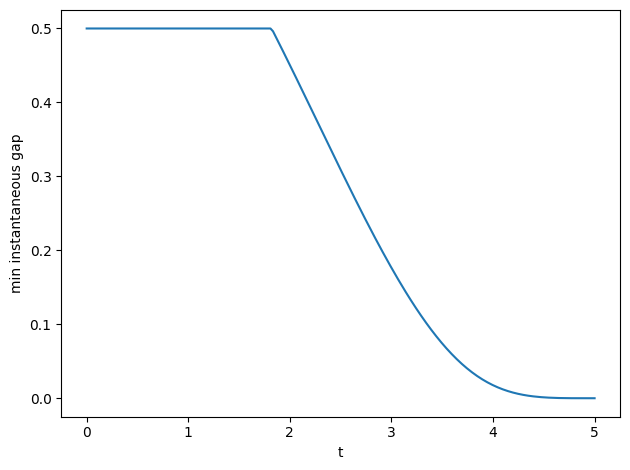

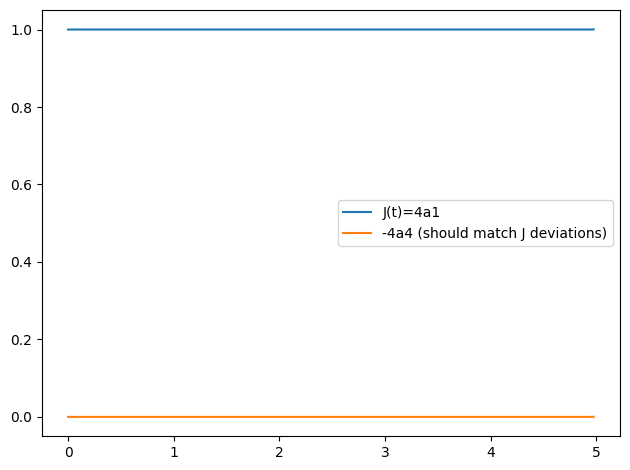

In [56]:
def min_gap_over_t(T, J, Nt):
    tgrid = np.linspace(0, T, Nt)
    gaps = []
    for t in tgrid:
        evals, _ = np.linalg.eigh(hamiltonian_permuted(t, T, J))
        evals = np.sort(evals.real)
        gaps.append(np.min(np.diff(evals)))
    return tgrid, np.array(gaps)

tg, gaps = min_gap_over_t(T, J, 200)
print("min gap =", gaps.min())

plt.figure()
plt.plot(tg, gaps)
plt.xlabel("t")
plt.ylabel("min instantaneous gap")
plt.tight_layout()
plt.show()

Nt = tgrid.size
yF = sol.y[:, -1]
a1 = yF[0:Nt]
a4 = yF[3*Nt:4*Nt]

plt.figure(); plt.plot(tgrid, 4*a1, label="J(t)=4a1")
plt.plot(tgrid, -4*a4, label="-4a4 (should match J deviations)")
plt.legend(); plt.tight_layout(); plt.show()

